In [1]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import wave
import struct
from collections import defaultdict
from python_scripts.read_xwav_header import read_xwav_header
from scipy.io import wavfile
import scipy
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
FILENAME = './data/audio_data/pifsc_audio_pipan_hawaii_pipan_hawaii_01_audio_Hawaii_K_01_070915_204730 (1).d20.x.wav'

In [3]:
model = hub.load('https://www.kaggle.com/models/google/humpback-whale/frameworks/TensorFlow2/variations/humpback-whale/versions/1')

In [8]:
# FILENAME = './data/audio_data/pifsc_audio_pipan_hawaii_pipan_hawaii_01_audio_Hawaii_K_01_070915_204730 (1).d20.x.wav'
FILENAME = './data/audio_data/pifsc_audio_pipan_hawaii_pipan_hawaii_02_audio_Hawaii_K_02_080506_173715.d20.x.wav'
samplerate, wav_data = wavfile.read(FILENAME)
# model = hub.load('https://www.kaggle.com/models/google/humpback-whale/frameworks/TensorFlow2/variations/humpback-whale/versions/1')

waveform, sample_rate = tf.audio.decode_wav(tf.io.read_file(FILENAME))
waveform = tf.expand_dims(waveform, 0)  # makes a batch of size 1
data = read_xwav_header(FILENAME)
pcen_spectrogram = model.front_end(waveform, num_channels=400,)
context_window = pcen_spectrogram[:, :128, :]
features = model.features(context_window)

C:\Users\adria\AppData\Local\Temp\ipykernel_8872\2518995865.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, wav_data = wavfile.read(FILENAME)


ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * <tf.Tensor 'inputs:0' shape=(1, 22500000, 1) dtype=float32>
    * False
    * None
  Keyword arguments: {'num_channels': 400}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='inputs')
    * True
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='input_1')
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='input_1')
    * False
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='inputs')
    * False
    * None
  Keyword arguments: {}

In [7]:
waveform = tf.expand_dims(waveform, 0)  # makes a batch of size 1
context_step_samples = tf.cast(sample_rate, tf.int64)
context_step_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [13]:
wav_data.shape

(22500000,)

In [31]:
pcen_spectrogram.shape

TensorShape([1, 74997, 64])

In [6]:
# There are 30 subchunks (0-29) of data in the xwav file, each subchunk is 75 seconds
# Spectrogram is 75,000 time bins by 64 frequency bins
# 23 sub chunks and 17 seconds
start = ((23 * 75) + 17) / (75 * 30)
end = ((23 * 75) + 18) / (75*30)
seconds = 75*30
step = 75000 / seconds
start * 75000, end * 75000

(58066.66666666667, 58099.99999999999)

In [7]:
num_samples = wav_data.shape[0]
sample_start = start * num_samples
sample_end = end * num_samples
sample_start, sample_end

(17420000.0, 17430000.0)

In [5]:
start_ind, end_ind = 17000000, 18000000
plot_data = wav_data[start_ind: end_ind]
plot_data.shape

(1000000,)

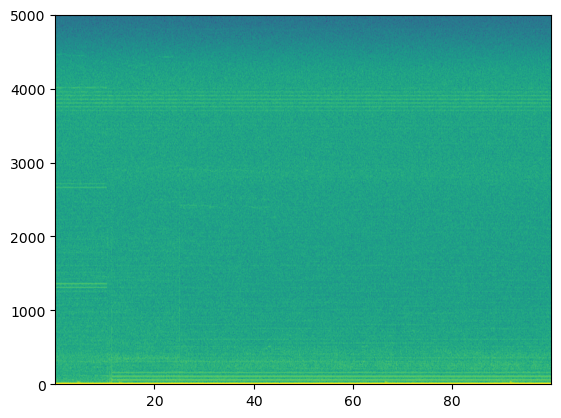

In [6]:
plt.specgram(plot_data, Fs=10_000, NFFT=1024, scale_by_freq=False)[1]
plt.show()

In [10]:
from scipy.signal import ShortTimeFFT

In [26]:
w = scipy.signal.windows.hann(1024)
SFT = scipy.signal.ShortTimeFFT(w, hop=300, fs = 10_000, scale_to='psd')
Sx = SFT.stft(plot_data)
Sx2 = SFT.spectrogram(plot_data)

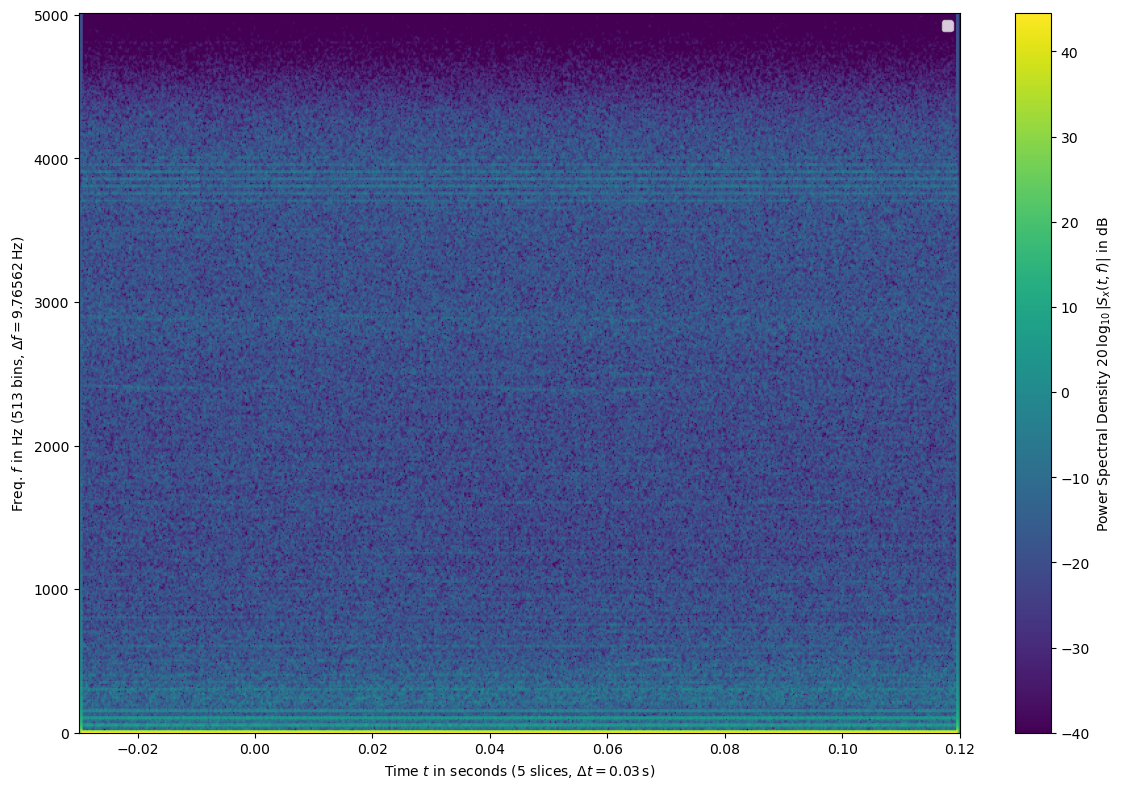

In [27]:
fig1, ax1 = plt.subplots(figsize=(12., 8.))  # enlarge plot a bit
N = len(Sx2)  # number of slices
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))
Sx_dB = 10 * np.log10(np.fmax(Sx2, 1e-4))  # limit range to -40 dB
im1 = ax1.imshow(Sx_dB, origin='lower', aspect='auto',
                 extent=SFT.extent(N))
fig1.colorbar(im1, label='Power Spectral Density ' +
                         r"$20\,\log_{10}|S_x(t, f)|$ in dB")

# Shade areas where window slices stick out to the side:
# for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
#                  (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
#     ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.3)
# for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line
#     ax1.axvline(t_, color='c', linestyle='--', alpha=0.5)
ax1.legend()
fig1.tight_layout()
plt.show()

In [19]:
Sx.shape

(513, 670)

In [32]:
58066+128

58194

In [24]:
step

33.333333333333336

In [5]:
context_window = pcen_spectrogram[:, 58066:58194, :]
context_window.shape

TensorShape([1, 128, 64])

In [6]:
image = context_window.numpy()[0]

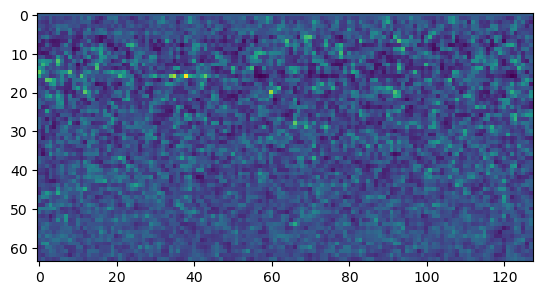

In [8]:
plt.imshow(image.T)

In [14]:
ds = Dataset("data/other_data/sanctsound_products_detections_ci01_sanctsound_ci01_01_bluewhale_data_SanctSound_CI01_01_bluewhale.nc")

In [15]:
ds.variables

{'time_stamp': <class 'netCDF4._netCDF4.Variable'>
 vlen time_stamp(time)
     actual_range: ['2018-11-07T22:02:01:456Z', '2018-11-15T20:11:22:288Z']
     axis: T
     long_name: Timestamp in ISO 8601 date format
     standard_name: time
     comment: Start time of detections
     units: milliseconds
 vlen data type: <class 'str'>
 unlimited dimensions: 
 current shape = (49,),
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     actual_range: [1541628121456 1542312682288]
     axis: T
     long_name: Time
     standard_name: time
     time_origin: 01-JAN-1970 00:00:00
     units: milliseconds since 1970-01-01T00:00:00Z
 unlimited dimensions: 
 current shape = (49,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'bluewhale_presence': <class 'netCDF4._netCDF4.Variable'>
 int32 bluewhale_presence(time)
     actual_range: [0 1]
     comment: Presence of Blue Whale (0 = not present; 1 = present)
     standard_name: bluewhale_presence
     long_name: blue w

In [2]:
import wave as wav

In [33]:
with wav.open(FILENAME, 'rb') as f:
    print(f.getparams())
    frames = f.readframes(2)

_wave_params(nchannels=1, sampwidth=2, framerate=10000, nframes=22500000, comptype='NONE', compname='not compressed')


In [34]:
frames

b'\xcd\x01\x05\x02'

In [31]:
print(frames)

b'\xcd\x01'


In [32]:
int.from_bytes(frames, byteorder='big')

52481

In [35]:
from wave_chunk_parser.chunks import RiffChunk

In [45]:
with open(FILENAME, 'rb') as f:
    riff = RiffChunk.from_file(f)
    print(riff)
    

In [64]:
riff.get_chunk(b'fmt ').to_bytes

<bound method FormatChunk.to_bytes of <wave_chunk_parser.chunks.FormatChunk object at 0x0000023F0054DFC0>>

In [2]:
df = pd.read_csv("data/pifsc_products_detections_annotations.csv")

In [10]:
df[df['flac_compressed_xwav_object'].str.startswith("gs://bioacoustics")]

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc


In [4]:
df[df['label'] != "Other"]

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc
18,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,11,True,True,Mn,48.174,49.138,2007-09-15 21:02:03.174000+00:00,2007-09-15 21:02:04.138000+00:00
19,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,11,True,True,Mn,52.431,53.132,2007-09-15 21:02:07.431000+00:00,2007-09-15 21:02:08.132000+00:00
20,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,46.230,46.738,2007-09-15 21:03:16.230000+00:00,2007-09-15 21:03:16.738000+00:00
21,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,49.926,50.679,2007-09-15 21:03:19.926000+00:00,2007-09-15 21:03:20.679000+00:00
22,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,53.307,53.955,2007-09-15 21:03:23.307000+00:00,2007-09-15 21:03:23.955000+00:00
...,...,...,...,...,...,...,...,...,...,...
38852,validation,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,910,False,True,Background,0.000,75.000,2016-04-27 10:00:00+00:00,2016-04-27 10:01:15+00:00
38853,validation,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,1018,False,True,Background,0.000,75.000,2016-05-03 13:31:15+00:00,2016-05-03 13:32:30+00:00
38854,validation,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,137,False,True,Background,0.000,75.000,2016-05-04 13:31:15+00:00,2016-05-04 13:32:30+00:00
38855,validation,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,430,False,True,Background,0.000,75.000,2016-05-13 01:30:00+00:00,2016-05-13 01:31:15+00:00


In [73]:
df[(df['flac_compressed_xwav_object'].str.endswith("Hawaii_K_01_070915_204730.d20.x.flac")) & (df['label'] == "Mn")]

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc
18,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,11,True,True,Mn,48.174,49.138,2007-09-15 21:02:03.174000+00:00,2007-09-15 21:02:04.138000+00:00
19,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,11,True,True,Mn,52.431,53.132,2007-09-15 21:02:07.431000+00:00,2007-09-15 21:02:08.132000+00:00
20,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,46.230,46.738,2007-09-15 21:03:16.230000+00:00,2007-09-15 21:03:16.738000+00:00
21,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,49.926,50.679,2007-09-15 21:03:19.926000+00:00,2007-09-15 21:03:20.679000+00:00
22,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,53.307,53.955,2007-09-15 21:03:23.307000+00:00,2007-09-15 21:03:23.955000+00:00
23,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,14,True,True,Mn,28.164,28.795,2007-09-15 21:05:28.164000+00:00,2007-09-15 21:05:28.795000+00:00


In [12]:
def read_harp_chunk(wav_file):
    # Read the HARP chunk ID
    harp_chunk_id = wav_file.read(4)
    if harp_chunk_id != b'harp':
        raise ValueError("HARP chunk not found")

    # Read the HARP chunk size
    harp_chunk_size = struct.unpack('<I', wav_file.read(4))[0]
    if harp_chunk_size != 56 + 30 * 32:
        raise ValueError("Unexpected HARP chunk size")

    # Read the HARP chunk data
    harp_chunk_data = {}
    harp_chunk_data['WavVersionNumber'] = struct.unpack('B', wav_file.read(1))[0]
    harp_chunk_data['FirmwareVersionNumber'] = wav_file.read(10)
    harp_chunk_data['InstrumentID'] = wav_file.read(4)
    harp_chunk_data['SiteName'] = wav_file.read(4)
    harp_chunk_data['ExperimentName'] = wav_file.read(8).rstrip(b'\x00')
    harp_chunk_data['DiskSequenceNumber'] = struct.unpack('B', wav_file.read(1))[0]
    harp_chunk_data['DiskSerialNumber'] = wav_file.read(8)
    harp_chunk_data['NumOfRawFiles'] = struct.unpack('<H', wav_file.read(2))[0]
    harp_chunk_data['Longitude'] = struct.unpack('<i', wav_file.read(4))[0]
    harp_chunk_data['Latitude'] = struct.unpack('<i', wav_file.read(4))[0]
    harp_chunk_data['Depth'] = struct.unpack('<H', wav_file.read(2))[0]
    wav_file.read(8)  # Reserved

    return harp_chunk_data

# Open the xwav file
with wave.open(FILENAME, 'rb') as wav_file:
    # Skip the standard WAV header
    wav_file.readframes(36)

    # Read the HARP chunk
    harp_chunk_data = read_harp_chunk(wav_file)

    # Print the HARP chunk data
    print(harp_chunk_data)

AttributeError: 'Wave_read' object has no attribute 'read'

In [87]:
chunk_data = {}
harp_data = {}
hapr_subchunk_data = defaultdict(dict)
with open(FILENAME, 'rb') as audio_file:
    chunk_data["chunk_id"] = struct.unpack('@4s', audio_file.read(4))[0]
    chunk_data["chunk_size"] = struct.unpack('@I', audio_file.read(4))[0]
    chunk_data["format"] = struct.unpack('@4s', audio_file.read(4))[0]
    chunk_data["subchunk1_id"] = struct.unpack('@4s', audio_file.read(4))[0]
    chunk_data["subchunk1_size"] = struct.unpack('@I', audio_file.read(4))[0]
    chunk_data["audio_format"] = struct.unpack('@H', audio_file.read(2))[0]
    chunk_data["num_channels"] = struct.unpack('@H', audio_file.read(2))[0]
    chunk_data["sample_rate"] = struct.unpack('@I', audio_file.read(4))[0]
    chunk_data["byte_rate"] = struct.unpack('@I', audio_file.read(4))[0]
    chunk_data["block_align"] = struct.unpack('@H', audio_file.read(2))[0]
    chunk_data["bits_per_sample"] = struct.unpack('@H', audio_file.read(2))[0]
    
    harp_data["harp_subchunk_id"] = struct.unpack('@4s', audio_file.read(4))[0]
    harp_data["harp_subchunk_size"] = struct.unpack('@I', audio_file.read(4))[0]
    harp_data["wav_version_number"] = struct.unpack('@B', audio_file.read(1))[0]
    harp_data["firmware_version_number"] = struct.unpack('@10s', audio_file.read(10))[0]
    harp_data["instrument_id"] = struct.unpack('@4s', audio_file.read(4))[0]
    harp_data["site_name"] = struct.unpack('@4s', audio_file.read(4))[0]
    harp_data["experiment_name"] = struct.unpack('@8s', audio_file.read(8))[0]
    harp_data["disk_sequence_number"] = struct.unpack('@B', audio_file.read(1))[0]
    harp_data["disk_serial_number"] = struct.unpack('@8s', audio_file.read(8))[0]
    harp_data["num_of_raw_files"] = struct.unpack('@H', audio_file.read(2))[0]
    harp_data["longitude"] = struct.unpack('@i', audio_file.read(4))[0] / 100_000  # file says it could be unsigned 
    harp_data["latitude"] = struct.unpack('@i', audio_file.read(4))[0] / 100_000  # files says it could be unsigned
    harp_data["depth"] = struct.unpack('@H', audio_file.read(2))[0]
    harp_data["reserved"] = struct.unpack('@8s', audio_file.read(8))[0]
    
    for i in range(harp_data["num_of_raw_files"]):
        hapr_subchunk_data[i]["year"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["month"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["day"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["hour"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["minute"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["second"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["ticks"] = struct.unpack('@H', audio_file.read(2))[0]
        hapr_subchunk_data[i]["byte_loc"] = struct.unpack('@I', audio_file.read(4))[0]
        hapr_subchunk_data[i]["byte_len"] = struct.unpack('@I', audio_file.read(4))[0]
        hapr_subchunk_data[i]["write_length"] = struct.unpack('@I', audio_file.read(4))[0]
        hapr_subchunk_data[i]["sample_rate"] = struct.unpack('@I', audio_file.read(4))[0]
        hapr_subchunk_data[i]["gain"] = struct.unpack('@B', audio_file.read(1))[0]
        hapr_subchunk_data[i]["padding"] = struct.unpack('@7p', audio_file.read(7))[0]
    x = audio_file.read(20)
chunk_data        

{'chunk_id': b'RIFF',
 'chunk_size': 45001060,
 'format': b'WAVE',
 'subchunk1_id': b'fmt ',
 'subchunk1_size': 16,
 'audio_format': 1,
 'num_channels': 1,
 'sample_rate': 10000,
 'byte_rate': 20000,
 'block_align': 2,
 'bits_per_sample': 16}

In [63]:
x

b'data@\xa5\xae\x02\xcd\x01\x05\x02#\x02\x0b\x02(\x02\xfd\x01'

In [70]:
harp_data

{'harp_subchunk_id': b'harp',
 'harp_subchunk_size': 1016,
 'wav_version_number': 1,
 'firmware_version_number': b'1.17B\x00\x00\x00\x00\x00',
 'instrument_id': b'DL25',
 'site_name': b'dep1',
 'experiment_name': b'HAWAII01',
 'disk_sequence_number': 11,
 'disk_serial_number': b'12345678',
 'num_of_raw_files': 30,
 'longitude': -156.0152,
 'latitude': 19.5815,
 'depth': 630,
 'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00'}

In [88]:
hapr_subchunk_data

defaultdict(dict,
            {0: {'year': 7,
              'month': 9,
              'day': 15,
              'hour': 20,
              'minute': 47,
              'second': 30,
              'ticks': 0,
              'byte_loc': 1068,
              'byte_len': 1500000,
              'write_length': 3000,
              'sample_rate': 10000,
              'gain': 10,
              'padding': b''},
             1: {'year': 7,
              'month': 9,
              'day': 15,
              'hour': 20,
              'minute': 48,
              'second': 45,
              'ticks': 0,
              'byte_loc': 1501068,
              'byte_len': 1500000,
              'write_length': 3000,
              'sample_rate': 10000,
              'gain': 1,
              'padding': b''},
             2: {'year': 7,
              'month': 9,
              'day': 15,
              'hour': 20,
              'minute': 50,
              'second': 0,
              'ticks': 0,
              'byte_loc': 30

In [75]:
(16501068-1068)/20_000

825.0

In [76]:
825+48.174

873.174

In [64]:
with open(FILENAME, 'rb') as audio_file:
    raw_data = audio_file.read()

In [66]:
raw_data[6001060: 6001072]

b'&\x02#\x02\x19\x02\x16\x02\xf5\x01H\x02'

In [65]:
raw_data[6001068:6001072], struct.unpack('@I', raw_data[6001072:6001076])

(b'\xf5\x01H\x02', (35914326,))

In [50]:
# print out 100 bytes at a time and label
for i in range(0, len(raw_data), 100):
    print(i, raw_data[i:i+100], end='\n\n')

0 b"RIFFd\xa9\xae\x02WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x10'\x00\x00 N\x00\x00\x02\x00\x10\x00harp\xf8\x03\x00\x00\x011.17B\x00\x00\x00\x00\x00DL25dep1HAWAII01\x0b12345678\x1e\x00\x90\xf0\x11\xff\x06\xe1\x1d\x00v\x02\x00\x00\x00\x00\x00\x00\x00\x00"

100 b"\x07\t\x0f\x14/\x1e\x00\x00,\x04\x00\x00`\xe3\x16\x00\xb8\x0b\x00\x00\x10'\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\t\x0f\x140-\x00\x00\x8c\xe7\x16\x00`\xe3\x16\x00\xb8\x0b\x00\x00\x10'\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\t\x0f\x142\x00\x00\x00\xec\xca-\x00`\xe3\x16\x00\xb8\x0b\x00\x00\x10'\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\t\x0f\x14"

200 b"3\x0f\x00\x00L\xaeD\x00`\xe3\x16\x00\xb8\x0b\x00\x00\x10'\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\t\x0f\x144\x1e\x00\x00\xac\x91[\x00`\xe3\x16\x00\xb8\x0b\x00\x00\x10'\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\t\x0f\x145-\x00\x00\x0cur\x00`\xe3\x16\x00\xb8\x0b\x00\x00\x10'\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x07\t\x0f\x147\x00\x00\x00"

300 b"lX\x89\x00`\xe3\x

In [57]:
raw_data[1060:1064], f'{struct.unpack("@I", raw_data[1064:1068])[0]:,d}'

(b'data', '45,000,000')

In [58]:
1500000 * 30

45000000

In [16]:
dct = {}
dct['year'] = struct.unpack('@B', raw_data[100:101])
dct['month'] = struct.unpack('@B', raw_data[101:102])
dct['day'] = struct.unpack('@B', raw_data[102:103])
dct['hour'] = struct.unpack('@B', raw_data[103:104])
dct['minute'] = struct.unpack('@B', raw_data[104:105])
dct['second'] = struct.unpack('@B', raw_data[105:106])
dct['ticks'] = struct.unpack('@H', raw_data[106:108])
dct['byte_loc'] = struct.unpack('@I', raw_data[108:112])
dct['byte_len'] = struct.unpack('@I', raw_data[112:116])
dct['write_length'] = struct.unpack('@I', raw_data[116:120])
dct['sample_rate'] = struct.unpack('@I', raw_data[120:124])
dct['gain'] = struct.unpack('@B', raw_data[124:125])
dct['padding'] = struct.unpack('@7p', raw_data[125:132])


dct

{'year': (7,),
 'month': (9,),
 'day': (15,),
 'hour': (20,),
 'minute': (47,),
 'second': (30,),
 'ticks': (0,),
 'byte_loc': (1068,),
 'byte_len': (1500000,),
 'write_length': (3000,),
 'sample_rate': (10000,),
 'gain': (1,),
 'padding': (b'',)}

In [25]:
struct.unpack('@B', raw_data[132])
struct.unpack('@B', raw_data[133])
struct.unpack('@B', raw_data[134])
struct.unpack('@B', raw_data[135])

TypeError: a bytes-like object is required, not 'int'

In [28]:
raw_data[132], raw_data[133], raw_data[134], raw_data[135], raw_data[136], raw_data[137], raw_data[138], raw_data[139]

(7, 9, 15, 20, 48, 45, 0, 0)

In [31]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
alphabet[7+1], alphabet[9+1], alphabet[15+1], alphabet[20+1]

('i', 'k', 'q', 'v')

In [29]:
struct.unpack("@I", raw_data[136: 140])

(11568,)

In [35]:
chr(b"\x07")

TypeError: 'bytes' object cannot be interpreted as an integer

In [37]:
chr(7)

'\x07'

In [34]:
raw_data[132:133]

b'\x07'

In [39]:
for i, byte in enumerate(raw_data):
    print(i, chr(byte))

0 R
1 I
2 F
3 F
4 d
5 ©
6 ®
7 
8 W
9 A
10 V
11 E
12 f
13 m
14 t
15  
16 
17  
18  
19  
20 
21  
22 
23  
24 
25 '
26  
27  
28  
29 N
30  
31  
32 
33  
34 
35  
36 h
37 a
38 r
39 p
40 ø
41 
42  
43  
44 
45 1
46 .
47 1
48 7
49 B
50  
51  
52  
53  
54  
55 D
56 L
57 2
58 5
59 d
60 e
61 p
62 1
63 H
64 A
65 W
66 A
67 I
68 I
69 0
70 1
71 
72 1
73 2
74 3
75 4
76 5
77 6
78 7
79 8
80 
81  
82 
83 ð
84 
85 ÿ
86 
87 á
88 
89  
90 v
91 
92  
93  
94  
95  
96  
97  
98  
99  
100 
101 	
102 
103 
104 /
105 
106  
107  
108 ,
109 
110  
111  
112 `
113 ã
114 
115  
116 ¸
117 
118  
119  
120 
121 '
122  
123  
124 
125  
126  
127  
128  
129  
130  
131  
132 
133 	
134 
135 
136 0
137 -
138  
139  
140 
141 ç
142 
143  
144 `
145 ã
146 
147  
148 ¸
149 
150  
151  
152 
153 '
154  
155  
156 
157  
158  
159  
160  
161  
162  
163  
164 
165 	
166 
167 
168 2
169  
170  
171  
172 ì
173 Ê
174 -
175  
176 `
177 ã
178 
179  
180 ¸
181 
182  
183  
184 


In [77]:
raw_data[124]

1

In [86]:
with open(FILENAME, 'r+b') as audio_file:
    audio_file.seek(124)
    audio_file.write(b'\x0A')
#    raw_data = audio_file.read()

In [81]:
int(b'\x02')

ValueError: invalid literal for int() with base 10: b'\x02'

In [83]:
print(b'\x01')

b'\x01'
